In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from support import QLAgent, make_config_txt
import os
import pandas as pd
import os
import datetime
import scipy
import time



### Gym Version is 0.17.0

### 1. Hyperparameters for Run

In [117]:
alphas = [0.01]
for x in range(10,1000):
    if x % 50 == 0:
        alphas.append(x/1000)
alphas.append(1)


episodes = 1500
max_steps = 200
agents_per_setting = 50


env = gym.make('Taxi-v3')
env_name = 'Taxi-v3'
gamma = 0.9
epsilon = 0.9
epsilon_min = 0.05
epsilon_decay_rate = 0.01

training_folder = ('Run1-Taxiv3-alphas') #Folder where all data will be stored
print(alphas)

[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]


### 2. Training of Agents

In [4]:
seeds = np.load('seeds.npy')
os.mkdir(training_folder)
make_config_txt(training_folder, alphas, agents_per_setting, env_name, gamma, epsilon, epsilon_decay_rate, epsilon_min, episodes, max_steps)

for alpha in alphas:
    #making new folder that will hold all the agents data files
    os.mkdir(f'{training_folder}/agents_for_alpha_{alpha}')
    print(f'-----------Training ALPHA: {alpha}-----------')
    for n_agent in range (1,agents_per_setting+1):
        Agent = QLAgent(env, alpha, gamma, epsilon, epsilon_decay_rate, epsilon_min, episodes, max_steps)
        return_list, reward_per_step = Agent.train()
        np.save(f'{training_folder}/agents_for_alpha_{alpha}/agent_Q-Table_{n_agent}',Agent.Q)
        np.save(f'{training_folder}/agents_for_alpha_{alpha}/agent_reward_per_step_{n_agent}', reward_per_step)

#Storing Date and Time of final episode to keep track of duration of one training episode and ensure completion
with open(f"{training_folder}/config.txt", "a") as file:
    file.write(f'end_of_trainingrun: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')


-----------Training ALPHA: 0.1-----------


100%|██████████| 1500/1500 [00:12<00:00, 118.01it/s]


-----------Training ALPHA: 0.11-----------


100%|██████████| 1500/1500 [00:10<00:00, 148.77it/s]


In [6]:
for alpha in alphas:
    for n_agent in range (1,agents_per_setting+1):
        Return_array = np.array([])
        Return_array = Return_array[:,np.newaxis]
        for seed in seeds:
            Return_array = np.vstack((Return_array,Agent.evaluate(seed=seed)))
        np.save(f'{training_folder}/agents_for_alpha_{alpha}/agent_evaluation_return_{n_agent}', Return_array)

### 3. Statistical Analysis

#### Entropy

> - Die Base der Entropy muss die Anzahl der Klassen sein. Daher hier 6, weil wir 6 Aktionen haben im Taxi-v3

In [2]:
#making directories where figures will be saved
try: 
    os.mkdir(f'{training_folder}/figures')
except:
    pass
try:
    os.mkdir(f'{training_folder}/figures/entropy')
except:
    pass
try:
    os.mkdir(f'{training_folder}/temp')
except:
    pass

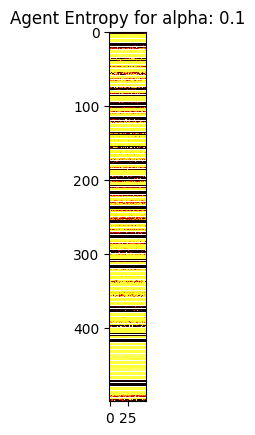

In [126]:
alpha = 0.1

agent_entropy_array = np.empty([500,0])


for n_agent in range(1,agents_per_setting +1):
    Q_table = np.load(f'{training_folder}/agents_for_alpha_{alpha}/agent_Q-Table_{n_agent}.npy')
    state_entropy = []

    for state in Q_table:

        # 1. calulate probabilites
        probabilites = np.exp(state)/sum(np.exp(state))
        # 2. calculate entropy with base6 for 6 actions
        state_entropy.append(scipy.stats.entropy(probabilites, base=6))


    state_entropy = np.array(state_entropy)  
    state_entropy = state_entropy[:,np.newaxis]
    agent_entropy_array = np.hstack((agent_entropy_array, state_entropy))

plt.imshow(agent_entropy_array, cmap='hot', interpolation='nearest')
plt.title(f'Agent Entropy for alpha: {alpha}')
plt.savefig(f'{training_folder}/figures/entropy/entropy_heatmap_alpha{alpha}.jpg', dpi=2000)

    

#### KL-Divergence

> - Berechnet wird die KL-Divergenz von jedem Agenten zu jedem Agenten
> - Dann wird davon der Durchschnitt berechnet. 

In [12]:
for alpha in alphas: 
    

NameError: name 'return_list' is not defined

In [13]:
for i in range(1,agents_per_setting+1):
    Agent = QLAgent(env, alpha, gamma, epsilon, epsilon_decay_rate, epsilon_min, episodes, max_steps)
    Return_List = Agent.train()
    df = pd.DataFrame(Agent.Q)

283
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
column_names = [x for x in range(1,Agent.max_steps+1)]
column_names.append('Argmax_Return')
df = pd.DataFrame(arr, columns=column_names)